---

<h1 style="color:#012eba">Introduction to Image Processing with Python</h1>
<h1 style="color:#012eba">Episode 7: Application of Image Processing in Machine Learning</h1>

---

*DASCI 261 - Introduction to Image Processing*

*Prepared by Erika G. Lacson*

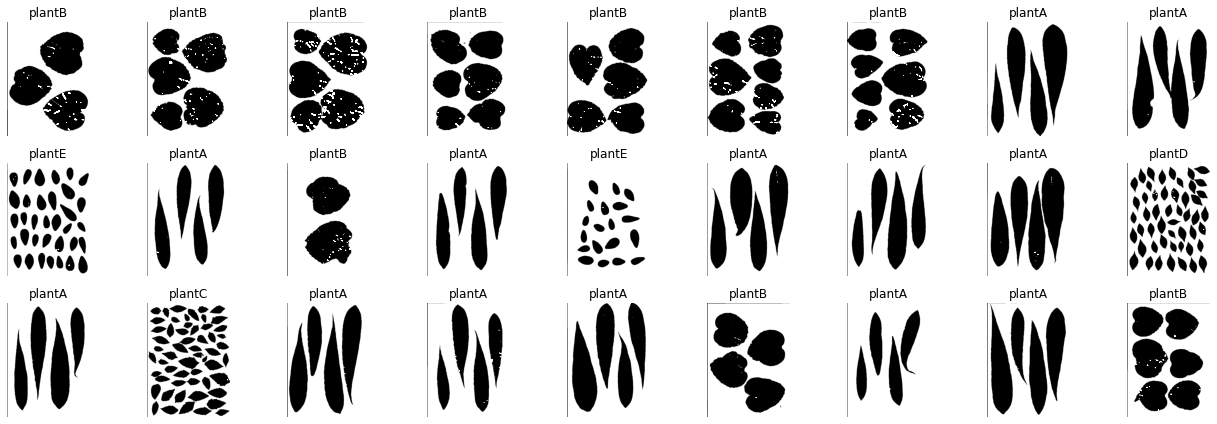

Photo by Borja, B. processed by Author.

---
<h2 style="color:#ff0090">Introduction</h2>

Hey there, image processing enthusiasts! 🖐️ Ready for another ride into the mesmerizing world of images and data? 🌍🔍 Brace yourselves, because Episode 7 is here! Today, we’ll venture into an exciting intersection of image processing and machine learning. Yes, you guessed it right! We’re going to explore the application of image processing in preparing our dataset for a machine learning algorithm.

Our challenge for today is Leaf Classification 🍃. We’ve already discussed how to visualize, enhance, and extract information from images in our previous episodes. Now, it’s time to utilize these algorithms and create a leaf classification algorithm. We’ll use our `Leaves` directory containing images of five classes of leaves. Our goal is to create a pipeline that would:

- Read and clean the images 📖
- Segment objects of interest 🎯
- Extract features from the objects 🧪
- Train an ML model 🚂

Remember, each step in our pipeline can significantly affect the accuracy of our model, and deciding which step to update will rely on heuristics. Time to put those learning hats on! 🎩

Before we proceed, let’s import the following libraries:

In [2]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import io, util
from skimage.color import rgb2gray
from skimage.morphology import binary_opening, disk
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops_table
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter all warnings
warnings.filterwarnings("ignore")

---
<h2 style="color:#ff0090">Section 1: Data Cleaning & Segmentation</h2>

Here, we're working on preparing our data. First, we read in our images and clean them by converting them to grayscale using `rgb2gray`. This simplifies the images and removes any variability due to color.

Then, we apply a method called Otsu's thresholding using `threshold_otsu` to segment the leaves (our objects of interest) from their background. 

After segmenting the leaves, we extract the features from each leaf using the skimage.measure's `regionprops_table`. Only selected `regionprops` properties were utilized after manually identifying and assessing the importance of each property (refer to my answer for question 3). I decided to use fewer and targeted properties because using all properties yielded poor results (77% test accuracy on the best model).

By visually checking the segmentation performed for each image, features with an `area` lower than `100` were excluded since those mostly pertain to artifacts in the images.

The extracted features and labels are stored in `leaves_data` and then converted into a DataFrame `df_leaves` for further processing.

<h3 style="color:#9e02bb">Read and clean the images</h3>

0it [00:00, ?it/s]

count of images for plantA: 13
count of images for plantB: 10
count of images for plantC: 1
count of images for plantD: 1
count of images for plantE: 2


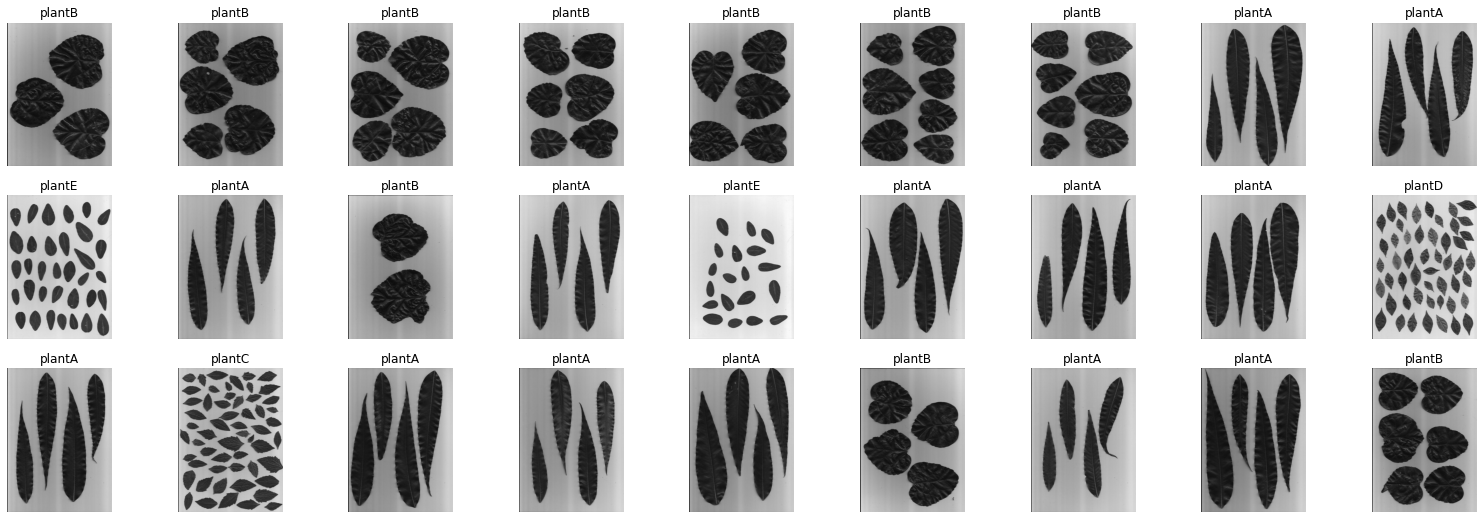

In [3]:
def read_and_clean_images(folder_path):
    """
    Reads all images from a folder, converts each image to grayscale, 
    and stores the raw and grayscale images in a DataFrame.
    
    Args:
    folder_path (str): The path to the folder containing the images.

    Returns:
    pd.DataFrame: A DataFrame containing the filename, raw image, and 
    grayscale image for each image.
    """
    images_data = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            image = imread(file_path)
            gray_image = rgb2gray(image)
            images_data.append({
                'filename': filename,
                'raw_image': image,
                'gray_image': gray_image
            })
    return pd.DataFrame(images_data)

folder_path = 'leaves'
images_data = read_and_clean_images(folder_path)

fig, axes = plt.subplots(3, 9, figsize=(27, 9))
plants = {'plantA': 0, 'plantB': 0, 'plantC': 0, 'plantD': 0, 'plantE': 0}

for ax, image_data in tqdm(zip(axes.flatten(), images_data.itertuples())):
    im = image_data.raw_image
    plant_type = os.path.splitext(image_data.filename.split('_')[0])[0]  # Extract the plant name from the filename and remove the file extension
    plants[plant_type] += 1
    ax.imshow(im)
    ax.set_title(plant_type)
    ax.axis(False)

for plant_type, count in plants.items():
    print(f'count of images for {plant_type}: {count}')


Leaves dataset. Original dataset from Borja, B., processed by the Author.

<h3 style="color:#9e02bb">Segment objects</h3>

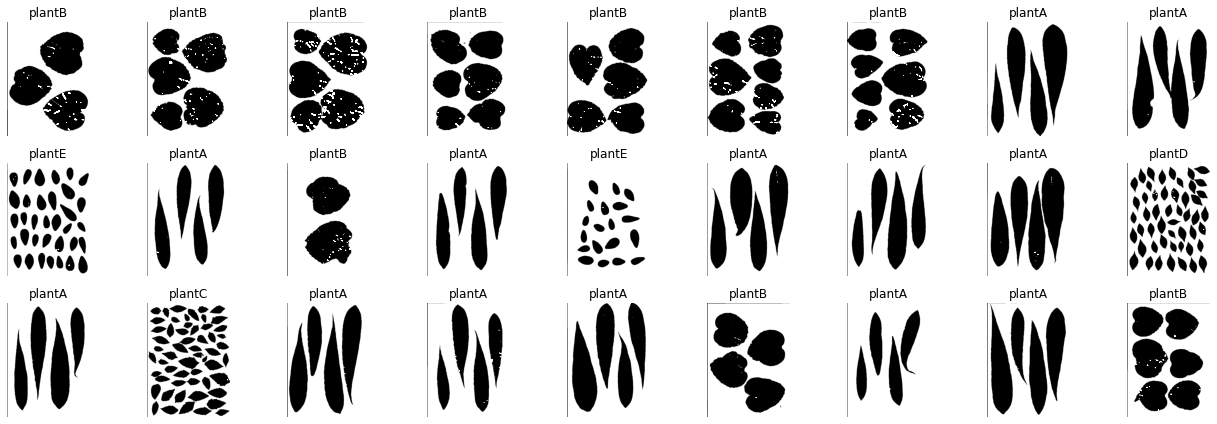

In [4]:
def segment_objects(data, image_names):
    """
    This function applies Otsu's thresholding method to segment the objects (leaves) 
    from the background for a list of images.
    """
    binary_images = []
    for image, name in zip(data, image_names):
        thresh_val = threshold_otsu(image)  # Otsu's thresholding
#         thresh_val = 0.38  # manual setting of threshold
        binary = image > thresh_val  # Binary image (segmented)
        labeled_image = label(binary)  # Label the connected components
        plant_type = os.path.splitext(name.split('_')[0])[0]  # Extract the plant type from the image name and remove the file extension
        binary_images.append((labeled_image, plant_type))
    return binary_images

def plot_segmented_images(images):
    """
    This function plots the segmented binary images in a 9 by 3 grid of subplots.
    """
    fig, axes = plt.subplots(nrows=3, ncols=9, figsize=(18, 6))
    for i, (image, plant_type) in enumerate(images):
        row = i // 9
        col = i % 9
        axes[row, col].imshow(image, cmap='gray', vmin=0, vmax=1)  # Set vmin=0 and vmax=1 for consistent brightness
        axes[row, col].axis('off')
        axes[row, col].set_title(plant_type)
    plt.tight_layout()
    plt.show()

# Segment the objects of interest from the images
binary_images = segment_objects(images_data['gray_image'], images_data['filename'])

# Plot the segmented images with plant types as names
plot_segmented_images(binary_images)


Binary leaves images. Original dataset from Borja, B., processed by the Author.

Once the leaves are segmented, we can then proceed to extract their features. Initially, I tried utilizing all the available features in the `regionprops` table. However, the low accuracy led me to examine each regionprops property more carefully. I settled on using only seven of these features for our machine learning model.

Here's a closer look at the properties I selected:

- **Eccentricity**: This property provides valuable information about the elongation or circularity of the leaf shape. Different plant species exhibit distinct elongation patterns that can be used for classification.

- **Solidity**: It measures the compactness of the leaf shape. Leaves with higher solidity values appear more solid and compact, while those with lower values may have irregular shapes. It helps in capturing the overall shape characteristics of the leaves.

- **Perimeter**: This gives insights into the outer boundary length of the leaf. Since leaves can have varying shapes and contours, considering the perimeter helps in identifying different boundary patterns among the leaves.

- **Area**: Leaf area can vary significantly across plant species. By incorporating the area property, we can take into account the overall size and coverage of the leaves, which can aid in distinguishing between different types.

- **Minor Axis Length and Major Axis Length**: These properties allow us to capture the size and dimensions of the leaves. Considering both minor and major axis lengths helps in accounting for their overall proportions and size, contributing to accurate classification.

- **Extent**: This measures the ratio of pixels in the region to the total number of pixels in the bounding box that encloses the region. It provides an indication of how much the region occupies the bounding box.

Interestingly, the **eccentricity** emerged as the top predictor in our machine learning implementation, illustrating the importance of elongation patterns in leaf classification. 🌱

In [5]:
def get_class(fpath):
    '''
    Extracts the class of the leaves from the filepath.
    '''
    return fpath.split('/')[1].split('.')[0].split('_')[0]

leaves_data = []
folder_path = 'leaves'

for filename in tqdm(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        image_raw = io.imread(file_path)
        gray_leaves = rgb2gray(image_raw[:,:,:3])

        thresh_val = threshold_otsu(gray_leaves)  # Otsu's thresholding
        binary_leaves = util.invert(gray_leaves > thresh_val)

#         binary_leaves = util.invert(gray_leaves > 0.389483762254902) # manual thresholding
        label_leaves = label(binary_leaves)

        props_table = regionprops_table(label_leaves, 
                                  properties=('label', 'area', 'eccentricity', 
                                              'major_axis_length', 
                                              'minor_axis_length', 
                                              'perimeter', 'solidity', 'extent'))

        props = [{k: v[i] for k, v in props_table.items()} for i in range(len(props_table['label']))]
        for prop in props:
            if prop['area'] > 100:
                prop['label'] = get_class(file_path)
                leaves_data.append(prop)

df_leaves = pd.DataFrame(data=leaves_data)


  0%|          | 0/27 [00:00<?, ?it/s]

---
<h2 style="color:#ff0090">Section 2: Model Training and Evaluation</h2>

In Section 2, we'll perform data splitting, model training, and model evaluation:

- Display the percentage distribution of each leaf class in the dataset.
- The labels are separated from the features and stored in labels.
- The data is split into training and test sets using `train_test_split`, with **80% for training and 20% for testing.**
- Stratified sampling is used to ensure a proportional distribution of the classes in both sets.
- The code creates pipelines with different classifiers (`KNN`, `Logistic Regression`, `SVC`, `Random Forest`, `Gradient Boosting`) and their corresponding hyperparameter grids.
- Grid search cross-validation is performed on each pipeline using `GridSearchCV` to find the best hyperparameters based on accuracy.
- The best model, determined by the pipeline with the highest accuracy, is stored in best_model for further evaluation.

In [6]:
label_counts = df_leaves['label'].value_counts()
total_count = label_counts.sum()
df_percentages = label_counts.to_frame().reset_index()
df_percentages.columns = ['label', 'count']
df_percentages['percentage'] = (df_percentages['count'] / total_count) * 100
print(f"Distribution (% representation) of each class or label:")
df_percentages

Distribution (% representation) of each class or label:


,label,count,percentage
0,plantA,64,22.535211
1,plantB,58,20.422535
2,plantC,56,19.718310
3,plantE,55,19.366197
4,plantD,51,17.957746


In [7]:
# pcc
pcc = ((df_leaves.label.value_counts() / df_leaves.label.value_counts().sum()) ** 2).sum()
print(f'PCC: {pcc:.3f}\n1.25PCC: {1.25 * pcc:.3f}')

PCC: 0.201
1.25PCC: 0.251


In [8]:
# Split the data
labels = df_leaves.pop('label')

train_data, test_data, train_labels, test_labels = train_test_split(df_leaves, labels, test_size=0.20, stratify=labels, random_state=42)

In [9]:
train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

((227, 7), (57, 7), (227,), (57,))

In [10]:
# Set seed for consistent results
random_seed = 42

pipelines = [
    ("knn", Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])),
    ("lr", Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=10000))])),
    ("svc", Pipeline([("scaler", StandardScaler()), ("svc", SVC())])),
    ("rf", Pipeline([("scaler", StandardScaler()), ("rf", RandomForestClassifier())])),
    ("gbm", Pipeline([("scaler", StandardScaler()), ("gbm", GradientBoostingClassifier())]))
]

param_grid = [
    {"knn__n_neighbors": [3, 5, 7, 9], "knn__weights": ["uniform", "distance"]},
    {"lr__C": [0.001, 0.01, 0.1, 1, 10, 100], "lr__penalty": ["l2"]},
    {"svc__C": [0.001, 0.01, 0.1, 1, 10, 100], "svc__gamma": [0.001, 0.01, 0.1, 1]},
    {"rf__n_estimators": [100, 150, 200, 250, 300, 350, 500], "rf__max_depth": [None, 3, 5, 7, 10, 20, 30, 50, 100]},
    {"gbm__learning_rate": [0.0001, 0.001, 0.01, 0.1, 1], "gbm__n_estimators": [100, 150, 200, 250, 300, 350, 500], "gbm__subsample": [0.5, 0.7, 1.0]}
]

grid_searches = []

for model_pipeline, model_param_grid in zip(pipelines, param_grid):
    gs = GridSearchCV(estimator=model_pipeline[1],
                      param_grid=model_param_grid,
                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                      n_jobs=-1)
    gs.fit(train_data, train_labels)
    grid_searches.append(gs)

# Get best model
best_gs = max(grid_searches, key=lambda x: x.best_score_)
best_model = best_gs.best_estimator_

display(best_model)


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(max_depth=20))])

**IMPORTANT NOTE**: 

- As we navigate through the machine learning process, it's crucial to remember that the number of samples can significantly impact model training. Limited samples can potentially lead to overfitting, where the model learns the training data very well but fails to perform equally well on unseen data. In my case, despite the limited number of samples, my best performing model achieved a test accuracy of 94.7%. However, this high performance might be due to chance and might not be repeatable with different data or even with a different split of the same data. It's essential to keep in mind the potential variability and uncertainty when dealing with a limited dataset.

---
<h2 style="color:#ff0090">Section 3: Results and Evaluation</h2>

Section 3 performs the evaluation of the models and stores the results in a DataFrame:

- The code loops through each grid search object and extracts relevant information such as the classifier name, best parameters, training accuracy, validation accuracy, and test accuracy.
- Additionally, it identifies the top feature (if applicable) that contributes the most to the classification task.
- The results are stored in a DataFrame `result_df` for further analysis and display.

In [11]:
result_data = []

for gs in grid_searches:
    classifier = gs.best_estimator_
    classifier_name = list(classifier.named_steps.keys())[-1]  # get the name of the last step of the pipeline
    best_params = gs.best_params_
    train_accuracy = gs.best_score_
    val_accuracy = cross_val_score(classifier, train_data, train_labels, cv=StratifiedKFold(n_splits=5)).mean()
    predictions = classifier.predict(test_data)
    test_accuracy = accuracy_score(test_labels, predictions)

    model = classifier.named_steps[classifier_name]  # get the actual model (the last step of the pipeline)
    if hasattr(model, 'feature_importances_'):
        top_feature_index = model.feature_importances_.argmax()
    elif hasattr(model, 'coef_'):
        if model.coef_.ndim > 1:
            # If coef_ is 2D, take the most important feature across all classes
            top_feature_index = np.abs(model.coef_).mean(axis=0).argmax()
        else:
            top_feature_index = model.coef_.argmax()
    else:
        top_feature_index = None
    top_feature = train_data.columns[top_feature_index] if top_feature_index is not None else None

    result_data.append({
        'classifier': classifier_name,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'top_predictor': top_feature,
        'best_parameters': best_params
    })

result_df = pd.DataFrame(result_data)
display(result_df)


,classifier,train_accuracy,val_accuracy,test_accuracy,top_predictor,best_parameters
0,knn,0.792464,0.806377,0.842105,None,"{'knn__n_neighbors': 7, 'knn__weights': 'dista..."
1,lr,0.792850,0.757778,0.859649,area,"{'lr__C': 100, 'lr__penalty': 'l2'}"
2,svc,0.858647,0.849952,0.929825,None,"{'svc__C': 100, 'svc__gamma': 1}"
3,rf,0.876329,0.889758,0.947368,eccentricity,"{'rf__max_depth': 20, 'rf__n_estimators': 100}"
4,gbm,0.858937,0.837005,0.947368,eccentricity,"{'gbm__learning_rate': 0.01, 'gbm__n_estimator..."


ML Results. Photo by Author.

---
<h2 style="color:#ff0090">Section 4: Final Evaluation and Metrics</h2>

Section 4 performs the final evaluation and displays the classification report, confusion matrix, and test accuracy of the best model selected from the grid search:

- The code generates a classification report showing `precision`, `recall`, `F1-score`, and support for each class.
- The confusion matrix is displayed to visualize the model's performance in predicting each class.
- The test accuracy of the best model is printed to provide an overall measure of its performance.

In [12]:
test_predictions = best_model.predict(test_data)
print(classification_report(test_labels, test_predictions))

# Show confusion matrix
conf_mat = confusion_matrix(test_labels, test_predictions)
conf_mat_df = pd.DataFrame(conf_mat, index=best_model.classes_, columns=best_model.classes_)
display(conf_mat_df)

print(f"Test Accuracy of Best Model: {accuracy_score(test_labels, test_predictions)}")

              precision    recall  f1-score   support

      plantA       1.00      1.00      1.00        13
      plantB       1.00      1.00      1.00        12
      plantC       0.90      0.82      0.86        11
      plantD       0.82      0.90      0.86        10
      plantE       1.00      1.00      1.00        11

    accuracy                           0.95        57
   macro avg       0.94      0.94      0.94        57
weighted avg       0.95      0.95      0.95        57



,plantA,plantB,plantC,plantD,plantE
plantA,13,0,0,0,0
plantB,0,12,0,0,0
plantC,0,0,9,2,0
plantD,0,0,1,9,0
plantE,0,0,0,0,11


Test Accuracy of Best Model: 0.9473684210526315


ML Test Results of using the Best Model. Photo by Author.

**IMPORTANT NOTE:**

- In this leaf classification task, I used several machine learning algorithms including `K-Nearest Neighbors (KNN)`, `Logistic Regression (LR)`, `Support Vector Machine (SVC)`, `Random Forest (RF)`, and `Gradient Boosting (GBM)`. Furthermore, I used `GridSearchCV` to tune the hyperparameters and find the best model. The best performing model, as determined by comparing the cross-validation scores of each model, turned out to be the `RandomForestClassifier` with max_depth=20 as the optimal parameter.

**Interpretation and Insights:**

The model performs perfectly in classifying `plantA`, `plantB`, and `plantE`, with a precision, recall, and F1-score of 1.00. However, it slightly struggles more with `plantC` and `plantD`, as indicated by their lower scores. Particularly, the `recall` of `plantC` is at `0.82` and `precision` of `plantD` is at `0.82`. This suggests that the model might be having difficulty distinguishing these two classes from each other or from other classes.

Considering the results above, we can further improve the model, perhaps by collecting more diverse data for `plantC` and `plantD`, or by using techniques to better balance the classes.

The confusion matrix indicates that most `misclassifications` happened between `plantC` and `plantD`. This suggests that these classes might be *similar* in some ways and might be harder for the model to distinguish. Understanding the characteristics of these classes could provide insights on why the model is confusing them and could guide feature engineering or data collection efforts.

As we move through this journey of image processing and machine learning, we need to remember that each step, each decision we make, can significantly impact the outcome. Today, we applied the skills we've learned so far and built a leaf classification algorithm, showcasing the power that lies at the intersection of image processing and machine learning.

And remember, while this was our best solution so far, it's important to iterate and experiment with different combinations of parameters, features, and techniques. So, keep exploring, keep learning, and until next time, happy coding! 👩‍💻👨‍💻🎉

---
<h2 style="color:#ff0090">Conclusion</h2>

As we conclude Episode 7, we reflect on the journey that we embarked on — the creation of an ML model that classifies leaves with a high level of accuracy. The essence of image processing techniques in preparing the dataset for our model was made clear, and the intriguing task of extracting features from leaf images to aid in classification was tackled.

However, this journey wasn’t without its trials. The task involved multiple iterations and numerous combinations of parameters, features, and techniques. It is through these trials that I achieved the final model, an illustration of our best solution.

In my initial attempts, I tried using all properties for feature extraction which led to a test accuracy of 77%. Despite this being a good start, I knew I could do better. By further refining the feature selection and incorporating class balancing, I improved the accuracy to 85.29%. A slight tweak in the selection of features bumped our accuracy a bit more to 86%.

During this process, I also considered employing a deep learning algorithm. However, given the nature of our dataset and the context of the task, it seemed to be an unnecessary complexity and might potentially overkill, so I decided to skip it.

In the end, I was left with an ML model that uses selected properties, yielding a promising test accuracy of 94.7%. It’s a testament to the power of iterative refinement and the importance of understanding the data you’re working with.

So here we are, at the end of Episode 7, having successfully traversed the fascinating path where image processing meets machine learning. I hope this journey has been as illuminating for you as it was for me. Stay tuned for more explorations into the world of data science and until then, happy learning!